In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Image filtering

## Image filtering theory

Filtering is one of the most basic and common image operations in image processing. You can filter an image to remove noise or to enhance features; the filtered image could be the desired result or just a preprocessing step. Regardless, filtering is an important topic to understand.

### Local filtering

In [2]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['image.cmap'] = 'gray'

The "local" in local filtering simply means that a pixel is adjusted by values in some surrounding neighborhood. These surrounding elements are identified or weighted based on a "footprint", "structuring element", or "kernel".

Let's go to back to basics and look at a 1D step-signal

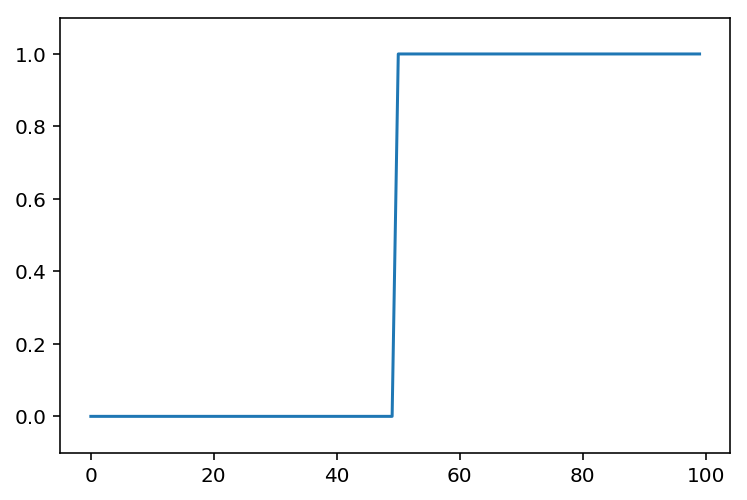

In [3]:
step_signal = np.zeros(100)
step_signal[50:] = 1
fig, ax = plt.subplots()
ax.plot(step_signal)
ax.margins(y=0.1)

Now add some noise to this signal:

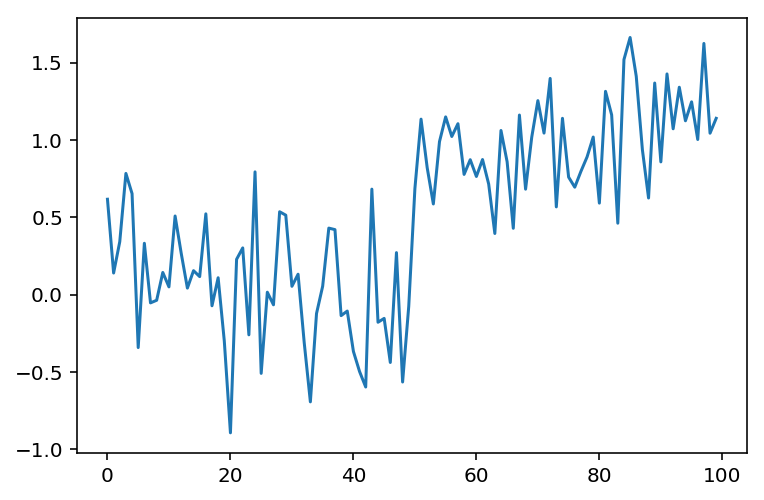

In [4]:
# Just to make sure we all see the same results
np.random.seed(0)


noisy_signal = (step_signal
                + np.random.normal(0, 0.35, step_signal.shape))
fig, ax = plt.subplots()
ax.plot(noisy_signal);

The simplest way to recover something that looks a bit more like the original signal is to take the average between neighboring "pixels":

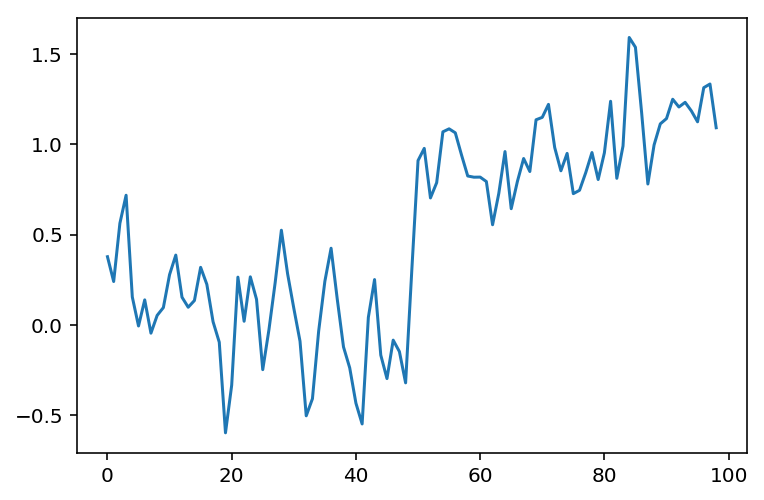

In [5]:
# Take the mean of neighboring pixels
smooth_signal = (noisy_signal[:-1] + noisy_signal[1:]) / 2.0
fig, ax = plt.subplots()
ax.plot(smooth_signal);

What happens if we want to take the *three* neighboring pixels? We can do the same thing:

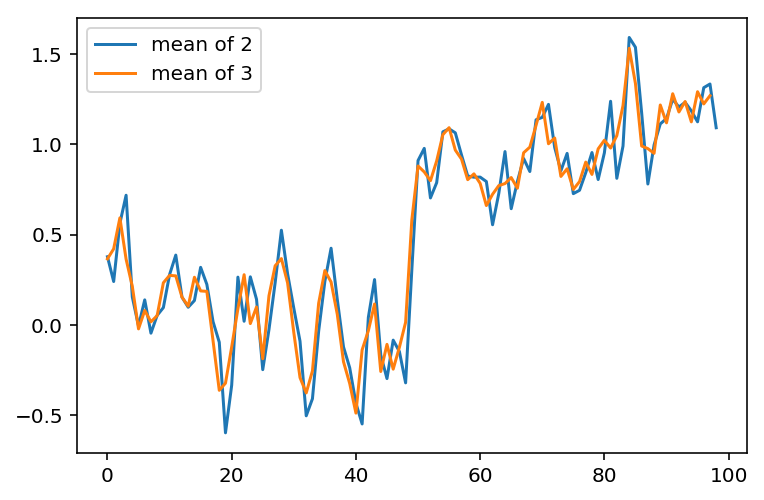

In [6]:
smooth_signal3 = (noisy_signal[:-2] + noisy_signal[1:-1]
                  + noisy_signal[2:]) / 3
fig, ax = plt.subplots()
ax.plot(smooth_signal, label='mean of 2')
ax.plot(smooth_signal3, label='mean of 3')
ax.legend(loc='upper left');

For averages of more points, the expression keeps getting hairier. And you have to worry more about what's going on in the margins. Is there a better way?

It turns out there is. This same concept, nearest-neighbor averages, can be expressed as a *convolution* with an *averaging kernel*. Note that the operation we did with `smooth_signal3` can be expressed as follows:

* Create an output array called `smooth_signal3`, of the same length as `noisy_signal`.
* At each element in `smooth_signal3` starting at point 1, and ending at point -2, place the average of the sum of: 1/3 of the element to the left of it in `noisy_signal`, 1/3 of the element at the same position, and 1/3 of the element to the right.
* discard the leftmost and rightmost elements.

This is called a *convolution* between the input image and the array `[1/3, 1/3, 1/3]`. (We'll give a more in-depth explanation of convolution in the next section).

smooth_signal3 and smooth_signal3p are equal: True


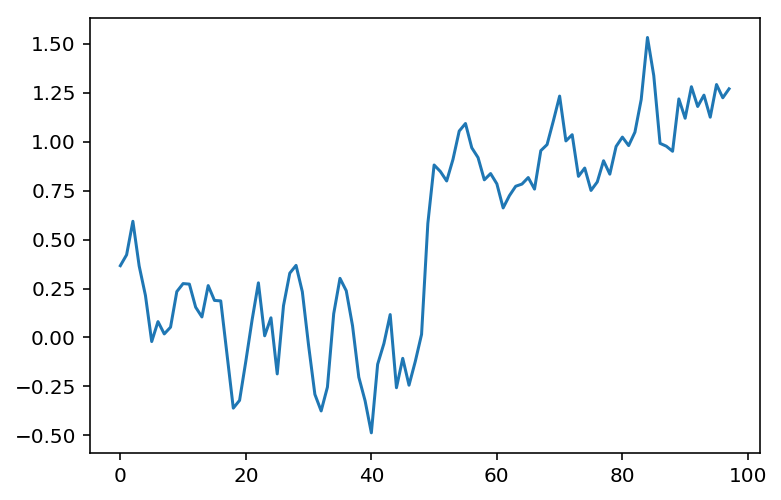

In [7]:
# Same as above, using a convolution kernel
# Neighboring pixels multiplied by 1/3 and summed
mean_kernel3 = np.full((3,), 1/3)
smooth_signal3p = np.convolve(noisy_signal, mean_kernel3,
                              mode='valid')
fig, ax = plt.subplots()
ax.plot(smooth_signal3p)

print('smooth_signal3 and smooth_signal3p are equal:',
      np.allclose(smooth_signal3, smooth_signal3p))

In [8]:
def convolve_demo(signal, kernel):
    ksize = len(kernel)
    convolved = np.correlate(signal, kernel)
    def filter_step(i):
        fig, ax = plt.subplots()
        ax.plot(signal, label='signal')
        ax.plot(convolved[:i+1], label='convolved')
        ax.legend()
        ax.scatter(np.arange(i, i+ksize),
                   signal[i : i+ksize])
        ax.scatter(i, convolved[i])
    return filter_step

from ipywidgets import interact, widgets

i_slider = widgets.IntSlider(min=0, max=len(noisy_signal) - 3,
                             value=0)

interact(convolve_demo(noisy_signal, mean_kernel3),
         i=i_slider);

interactive(children=(IntSlider(value=0, description='i', max=97), Output()), _dom_classes=('widget-interact',…

The advantage of convolution is that it's just as easy to take the average of 11 points as 3:

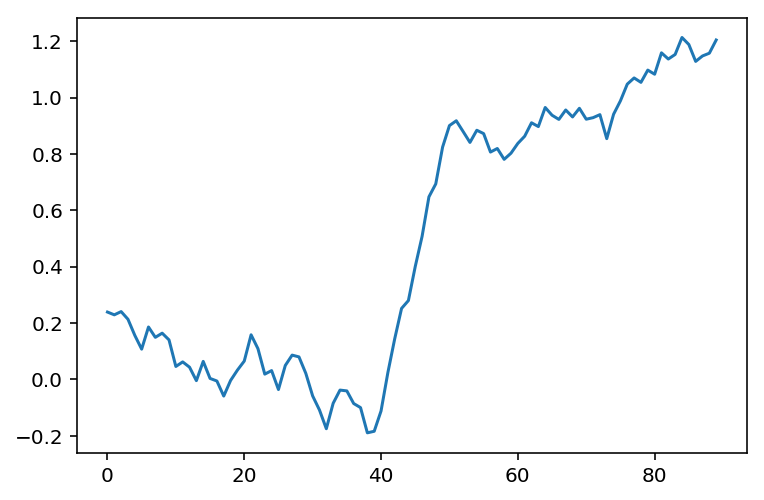

In [9]:
mean_kernel11 = np.full((11,), 1/11)
smooth_signal11 = np.convolve(noisy_signal, mean_kernel11,
                              mode='valid')
fig, ax = plt.subplots()
ax.plot(smooth_signal11);

In [10]:
i_slider = widgets.IntSlider(min=0, max=len(noisy_signal) - 11,
                             value=0)

interact(convolve_demo(noisy_signal, mean_kernel11),
         i=i_slider);

interactive(children=(IntSlider(value=0, description='i', max=89), Output()), _dom_classes=('widget-interact',…

Of course, to take the mean of 11 values, we have to move further and further away from the edges, and this starts to be noticeable. You can use `mode='same'` to pad the edges of the array and compute a result of the same size as the input:

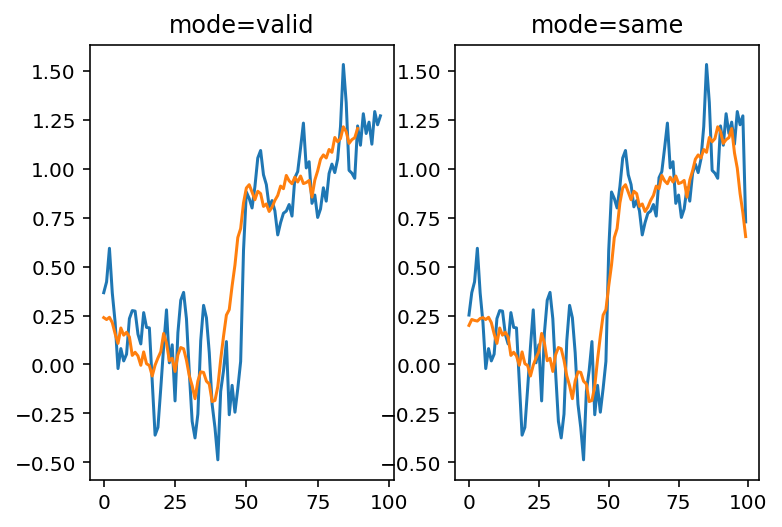

In [11]:
smooth_signal3same = np.convolve(noisy_signal, mean_kernel3,
                                 mode='same')
smooth_signal11same = np.convolve(noisy_signal, mean_kernel11,
                                  mode='same')

fig, ax = plt.subplots(1, 2)
ax[0].plot(smooth_signal3p)
ax[0].plot(smooth_signal11)
ax[0].set_title('mode=valid')
ax[1].plot(smooth_signal3same)
ax[1].plot(smooth_signal11same)
ax[1].set_title('mode=same');

But now we see edge effects on the ends of the signal...

This is because `mode='same'` actually pads the signal with 0s and then applies `mode='valid'` as before.

In [12]:
def convolve_demo_same(signal, kernel):
    ksize = len(kernel)
    padded_signal = np.pad(signal, ksize // 2,
                           mode='constant')
    convolved = np.correlate(padded_signal, kernel)
    def filter_step(i):
        fig, ax = plt.subplots()
        x = np.arange(-ksize // 2,
                      len(signal) + ksize // 2)
        ax.plot(signal, label='signal')
        ax.plot(convolved[:i+1], label='convolved')
        ax.legend()
        start, stop = i, i + ksize
        ax.scatter(x[start:stop]+1,
                   padded_signal[start : stop])
        ax.scatter(i, convolved[i])
        ax.set_xlim(-ksize // 2,
                    len(signal) + ksize // 2)
    return filter_step


i_slider = widgets.IntSlider(min=0, max=len(noisy_signal)-1,
                             value=0)

interact(convolve_demo_same(noisy_signal, mean_kernel11),
         i=i_slider);

interactive(children=(IntSlider(value=0, description='i', max=99), Output()), _dom_classes=('widget-interact',…

**Exercise** Look up the documentation of `scipy.ndimage.convolve`. Apply the same convolution, but using a different `mode=` keyword argument to avoid the edge effects we see here.

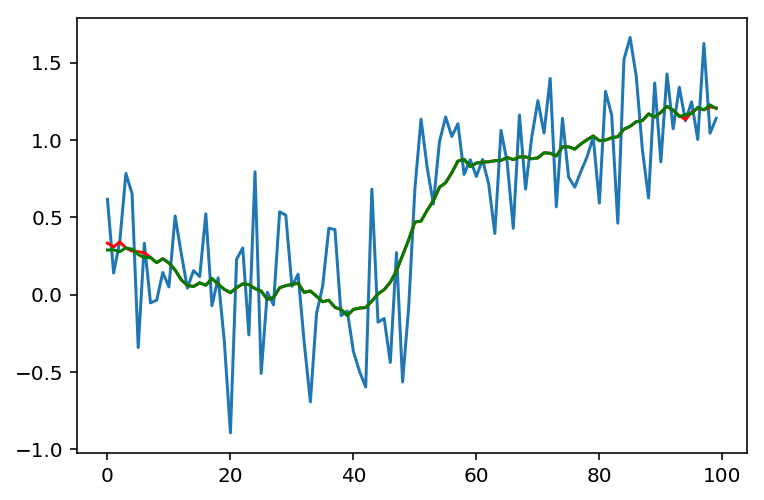

In [13]:
import scipy
from scipy.ndimage import convolve
smooth1 = convolve(noisy_signal, weights=np.full(15,1/15), mode='reflect')
smooth2 = convolve(noisy_signal, weights=np.full(15,1/15), mode='mirror')

plt.plot(noisy_signal, color='tab:blue')
plt.plot(smooth1, color='red')
plt.plot(smooth2, color='green');

#### A difference filter

Let's look again at our simplest signal, the step signal from before:

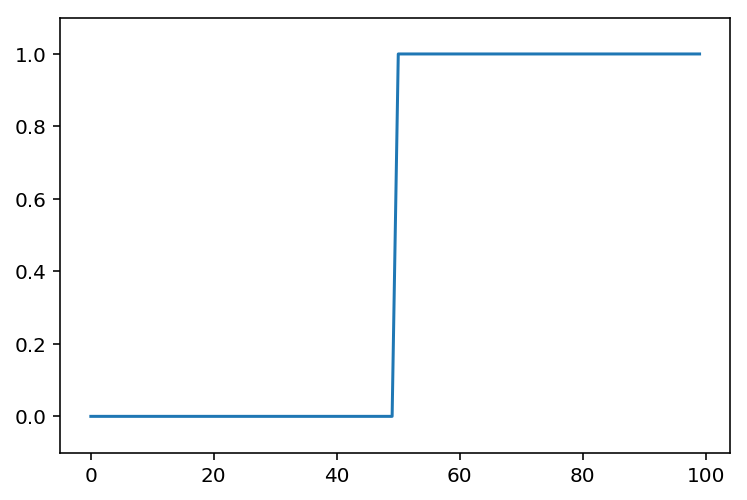

In [14]:
fig, ax = plt.subplots()
ax.plot(step_signal)
ax.margins(y=0.1) 

**Exercise:** Can you predict what a convolution with the kernel `[-1, 0, 1]` does? Try thinking about it before running the cells below.

In [15]:
result_corr = np.correlate(step_signal, np.array([-1, 0, 1]),
                           mode='valid')

In [16]:
result_conv = np.convolve(step_signal, np.array([-1, 0, 1]),
                          mode='valid')

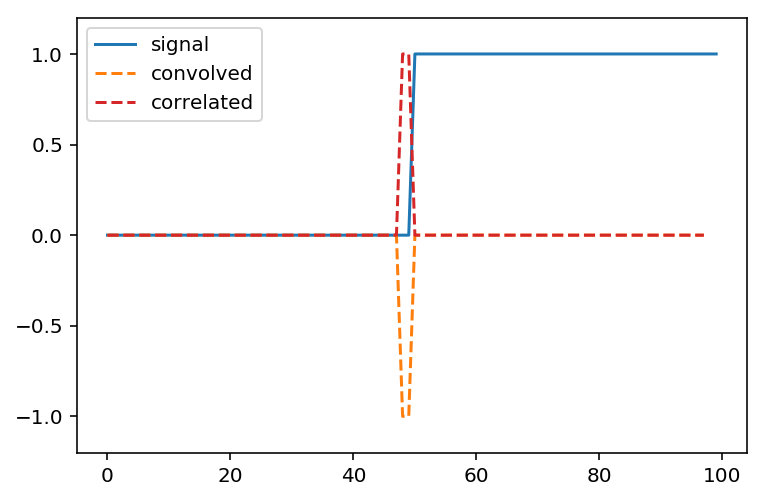

In [17]:
fig, ax = plt.subplots()
ax.plot(step_signal, label='signal')
ax.plot(result_conv, linestyle='dashed', label='convolved')
ax.plot(result_corr, linestyle='dashed', label='correlated',
        color='C3')
ax.legend(loc='upper left')
ax.margins(y=0.1) 

(For technical signal processing reasons, convolutions actually occur "back to front" between the input array and the kernel. Correlations occur in the signal order, so we'll use correlate from now on.)

#### Commutativity and assortativity of filters

What if we try the same trick with our noisy signal?

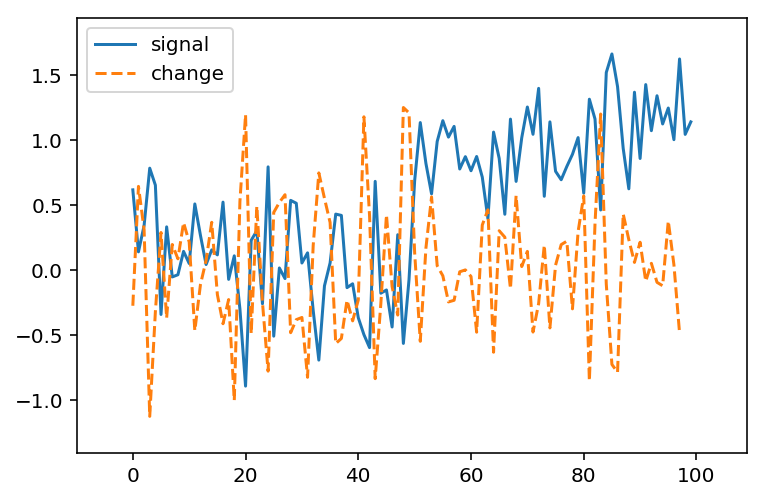

In [18]:
noisy_change = np.correlate(noisy_signal, np.array([-1, 0, 1]))

fig, ax = plt.subplots()
ax.plot(noisy_signal, label='signal')
ax.plot(noisy_change, linestyle='dashed', label='change')
ax.legend(loc='upper left')
ax.margins(0.1)

Oops! We lost our edge!

But recall that we smoothed the signal a bit by taking its neighbors. Perhaps we can do the same thing here. Actually, it turns out that we can do it *in any order*, so we can create a filter that combines both the difference and the mean:

In [19]:
mean_diff = np.correlate([-1, 0, 1], [1/3, 1/3, 1/3], mode='full')
print(mean_diff)

mean_diff_conv = np.convolve([-1, 0, 1], [1/3, 1/3, 1/3], mode='full')
print(mean_diff_conv)

[-0.33333333 -0.33333333  0.          0.33333333  0.33333333]
[-0.33333333 -0.33333333  0.          0.33333333  0.33333333]


*Note:* we use `np.convolve` here, because it has the option to output a *wider* result than either of the two inputs.

Now we can use this to find our edge even in a noisy signal:

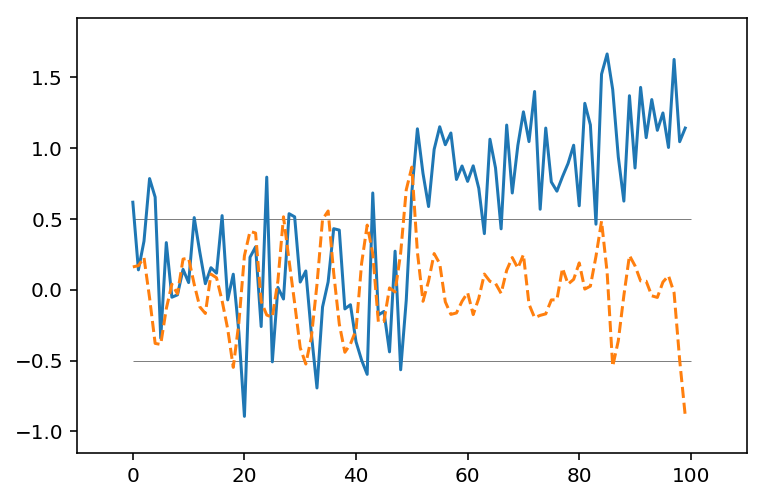

In [20]:
smooth_change = np.correlate(noisy_signal, mean_diff,
                             mode='same')
fig, ax = plt.subplots()
ax.plot(noisy_signal, label='signal')
ax.plot(smooth_change, linestyle='dashed', label='change')
ax.margins(0.1)
ax.hlines([-0.5, 0.5], 0, 100, linewidth=0.5, color='gray');

**Exercise:** The Gaussian filter with variance $\sigma^2$ is given by:

$$
k_i = \frac{1}{\sqrt{2\pi}\sigma}\exp{\left(-\frac{(x_i - x_0)^2}{2\sigma^2}\right)}
$$

1. Create this filter (for example, with width 9, center 4, sigma 1). (Plot it)
2. Convolve it with the difference filter (with appropriate mode). (Plot the result)
3. Convolve it with the noisy signal. (Plot the result)

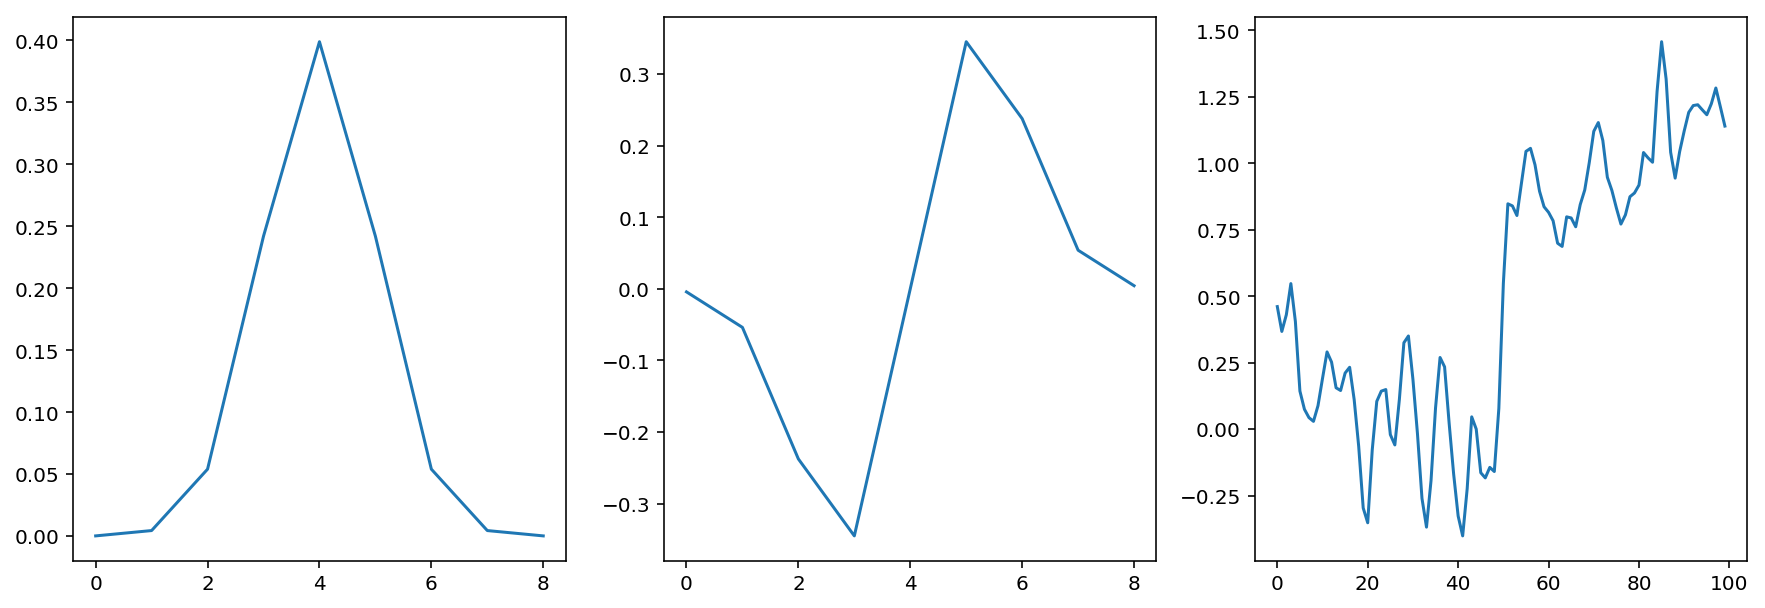

In [21]:
xi = np.arange(9)
x0 = 9 // 2  # 4
x = xi - x0
sigma=1

plt.figure(figsize=(15,5))
k = (1/ (np.sqrt(2 * np.pi)*sigma)) * np.exp(-1 * np.power(x, 2) / (2 * np.power(sigma,2)))
plt.subplot(131)
plt.plot(k);

convolved_with_diff = convolve(k, [-1,0,1])
plt.subplot(132)
plt.plot(convolved_with_diff);

noisy_convolved = convolve(noisy_signal, k)
plt.subplot(133)
plt.plot(noisy_convolved);

Whenever neighboring values are close, the filter response is close to 0. Right at the boundary of a step, we're subtracting a small value from a large value and and get a spike in the response. This spike "identifies" our edge.

## Local filtering of images

Now let's apply all this knowledge to 2D images instead of a 1D signal. Let's start with an incredibly simple image:

In [22]:
import numpy as np

bright_square = np.zeros((7, 7), dtype=float)
bright_square[2:5, 2:5] = 1

This gives the values below:

In [23]:
print(bright_square)

[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


and looks like a white square centered on a black square:

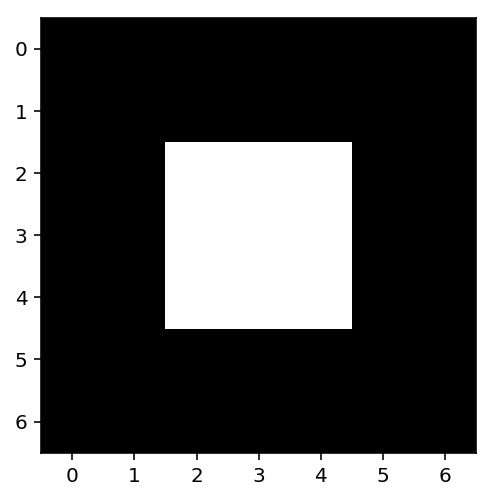

In [24]:
fig, ax = plt.subplots()
ax.imshow(bright_square);

### The mean filter

For our first example of a filter, consider the following filtering array, which we'll call a "mean kernel". For each pixel, a kernel defines which neighboring pixels to consider when filtering, and how much to weight those pixels.

In [25]:
mean_kernel = np.full((3, 3), 1/9)

print(mean_kernel)

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


Now, let's take our mean kernel and apply it to every pixel of the image.

Applying a (linear) filter essentially means:
* Center a kernel on a pixel
* Multiply the pixels *under* that kernel by the values *in* the kernel
* Sum all the those results
* Replace the center pixel with the summed result

This process is known as convolution.

Let's take a look at the numerical result:

In [26]:
import scipy.ndimage as ndi

%precision 2
print(bright_square)
print(ndi.correlate(bright_square, mean_kernel))


[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
[[0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.11 0.22 0.33 0.22 0.11 0.  ]
 [0.   0.22 0.44 0.67 0.44 0.22 0.  ]
 [0.   0.33 0.67 1.   0.67 0.33 0.  ]
 [0.   0.22 0.44 0.67 0.44 0.22 0.  ]
 [0.   0.11 0.22 0.33 0.22 0.11 0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]]


Let's see a convolution in action.

(Execute the following cell, but don't try to read it; its purpose is to generate an example.)

In [27]:
#--------------------------------------------------------------------------
#  Convolution Demo
#--------------------------------------------------------------------------
from skimage import color
from scipy import ndimage as ndi
from matplotlib import patches

def mean_filter_demo(image, vmax=1):
    mean_factor = 1.0 / 9.0  # This assumes a 3x3 kernel.
    iter_kernel_and_subimage = iter_kernel(image)

    image_cache = []

    def mean_filter_step(i_step):
        while i_step >= len(image_cache):
            filtered = image if i_step == 0 else image_cache[-1][-1][-1]
            filtered = filtered.copy()

            (i, j), mask, subimage = next(iter_kernel_and_subimage)
            filter_overlay = color.label2rgb(mask, image, bg_label=0,
                                             colors=('cyan', 'red'))
            filtered[i, j] = np.sum(mean_factor * subimage)
            image_cache.append(((i, j), (filter_overlay, filtered)))

        (i, j), images = image_cache[i_step]
        fig, axes = plt.subplots(1, len(images), figsize=(10, 5))
        
        for ax, imc in zip(axes, images):
            ax.imshow(imc, vmax=vmax)
            rect = patches.Rectangle([j - 0.5, i - 0.5], 1, 1, color='yellow', fill=False)
            ax.add_patch(rect)
            
        plt.show()
    return mean_filter_step


def mean_filter_interactive_demo(image):
    from ipywidgets import IntSlider, interact
    mean_filter_step = mean_filter_demo(image)
    step_slider = IntSlider(min=0, max=image.size-1, value=0)
    interact(mean_filter_step, i_step=step_slider)


def iter_kernel(image, size=1):
    """ Yield position, kernel mask, and image for each pixel in the image.

    The kernel mask has a 2 at the center pixel and 1 around it. The actual
    width of the kernel is 2*size + 1.
    """
    width = 2*size + 1
    for (i, j), pixel in iter_pixels(image):
        mask = np.zeros(image.shape, dtype='int16')
        mask[i, j] = 1
        mask = ndi.grey_dilation(mask, size=width)
        #mask[i, j] = 2
        subimage = image[bounded_slice((i, j), image.shape[:2], size=size)]
        yield (i, j), mask, subimage


def iter_pixels(image):
    """ Yield pixel position (row, column) and pixel intensity. """
    height, width = image.shape[:2]
    for i in range(height):
        for j in range(width):
            yield (i, j), image[i, j]


def bounded_slice(center, xy_max, size=1, i_min=0):
    slices = []
    for i, i_max in zip(center, xy_max):
        slices.append(slice(max(i - size, i_min), min(i + size + 1, i_max)))
    return tuple(slices)



In [28]:
mean_filter_interactive_demo(bright_square)

interactive(children=(IntSlider(value=0, description='i_step', max=48), Output()), _dom_classes=('widget-inter…

Incidentally, the above filtering is the exact same principle behind the *convolutional neural networks*, or CNNs, that you might have heard much about over the past few years. The only difference is that while above, the simple mean kernel is used, in CNNs, the values inside the kernel are *learned* to find a specific feature, or accomplish a specific task. Time permitting, we'll demonstrate this in an exercise at the end of the notebook.

The meaning of "mean kernel" should be clear now: Each pixel was replaced with the mean value within the 3x3 neighborhood of that pixel. When the kernel was over `n` bright pixels, the pixel in the kernel's center was changed to n/9 (= n * 0.111). When no bright pixels were under the kernel, the result was 0.

This filter is a simple smoothing filter and produces two important results:
1. The intensity of the bright pixel decreased.
2. The intensity of the region near the bright pixel increased.

Slight aside:

In [29]:
print(np.sum(mean_kernel))

1.0


Note that all the values of the kernel sum to 1. Why might that be important?

### Downsampled image

Let's consider a real image now. It'll be easier to see some of the filtering we're doing if we downsample the image a bit. We can slice into the image using the "step" argument to sub-sample it (don't scale images using this method for real work; use `skimage.transform.rescale`):

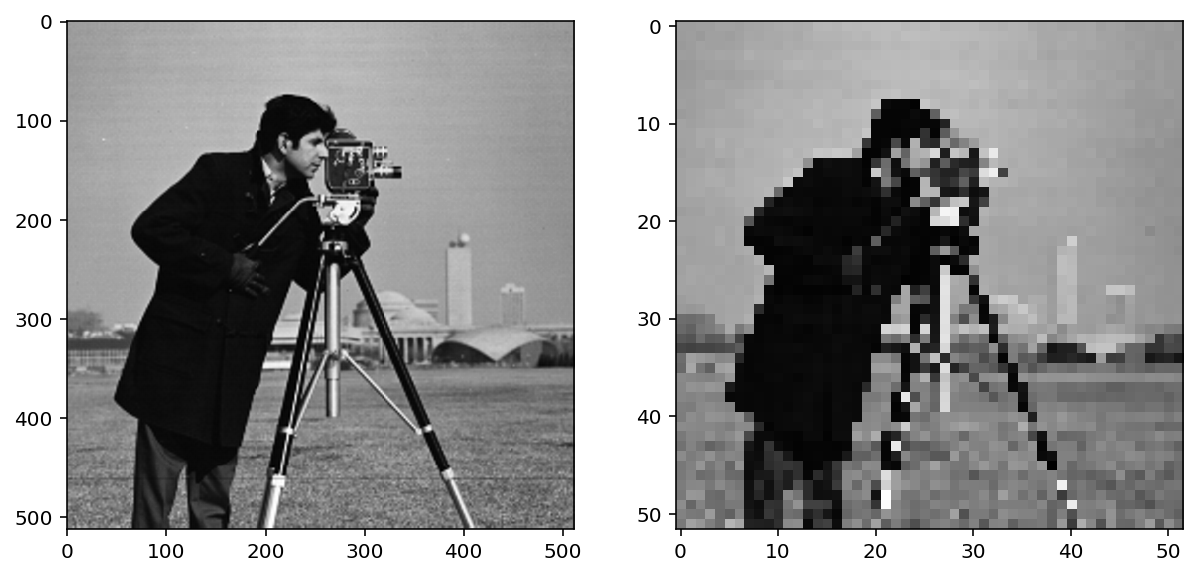

In [34]:
from skimage import data

image = data.camera()
pixelated = image[::10, ::10]
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
ax0.imshow(image)
ax1.imshow(pixelated) ;

We are actually going to be using the pattern of plotting multiple images side by side quite often, so we are going to make the following helper function:

In [35]:
from skimage import img_as_float

def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 5
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,
                             figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax)
        ax.set_title(label)


Here we use a step of 10, giving us every tenth column and every tenth row of the original image. You can see the highly pixelated result on the right.

### Mean filter on a real image

Now we can apply the filter to this downsampled image:

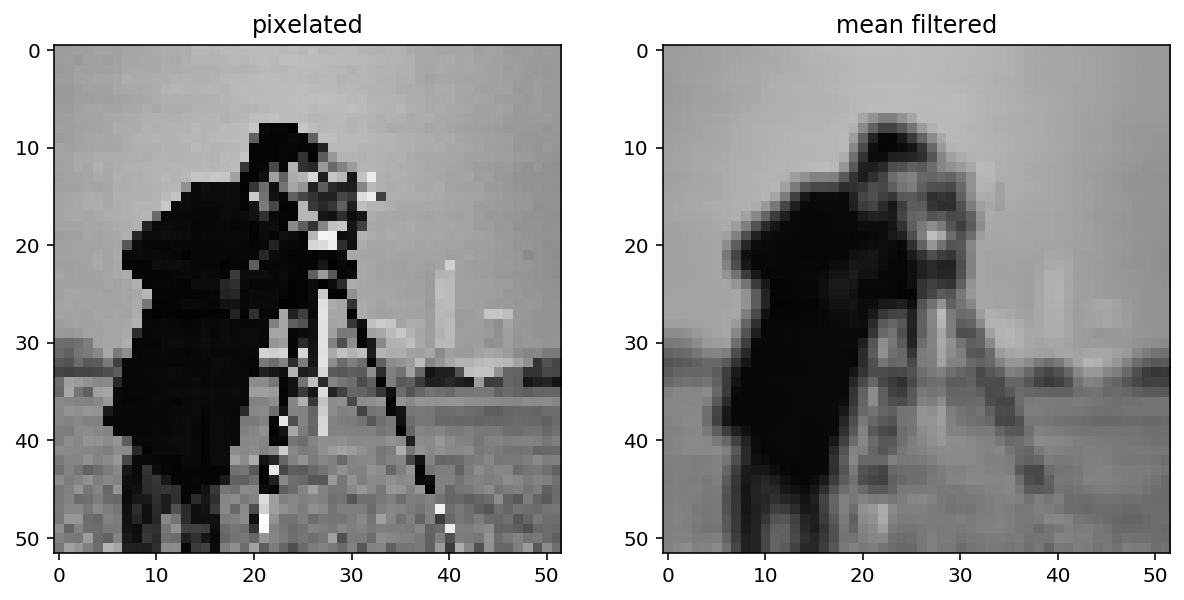

In [63]:
filtered = ndi.correlate(pixelated, mean_kernel)
imshow_all(pixelated, filtered, titles=['pixelated', 'mean filtered'])

Comparing the filtered image to the pixelated image, we can see that this filtered result is smoother: Sharp edges (which are just borders between dark and bright pixels) are smoothed because dark pixels reduce the intensity of neighboring pixels and bright pixels do the opposite.

## Essential filters

If you read through the last section, you're already familiar with the essential concepts of image filtering. But, of course, you don't have to create custom filter kernels for all of your filtering needs. There are many standard filter kernels pre-defined from half a century of image and signal processing.

### Gaussian filter

The classic image filter is the Gaussian filter. This is similar to the mean filter, in that it tends to smooth images. The Gaussian filter, however, doesn't weight all values in the neighborhood equally. Instead, pixels closer to the center are weighted more than those farther away.

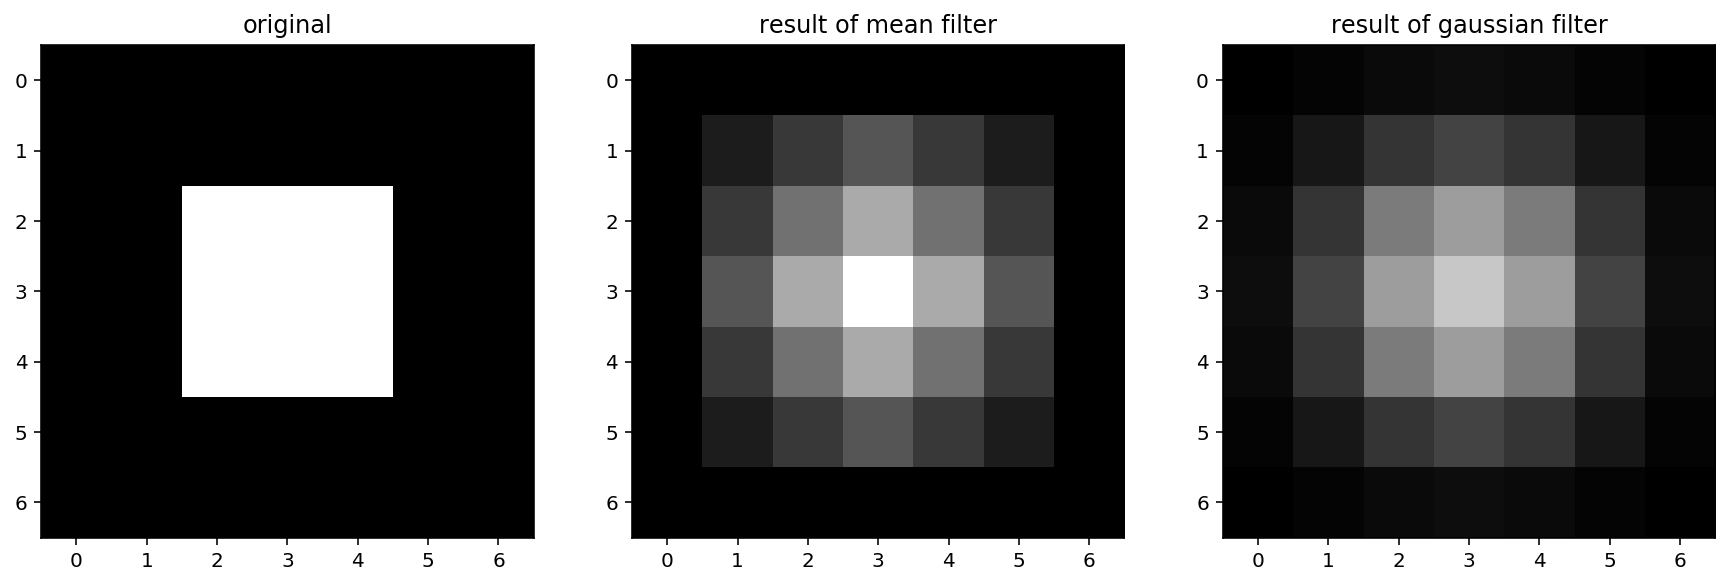

In [64]:
# Rename module so we don't shadow the builtin function
from skimage import filters

smooth_mean = ndi.correlate(bright_square, mean_kernel)
sigma = 1
smooth = filters.gaussian(bright_square, sigma)
imshow_all(bright_square, smooth_mean, smooth,
           titles=['original', 'result of mean filter', 'result of gaussian filter'])

For the Gaussian filter, `sigma`, the standard deviation, defines the size of the neighborhood.

For a real image, we get the following:

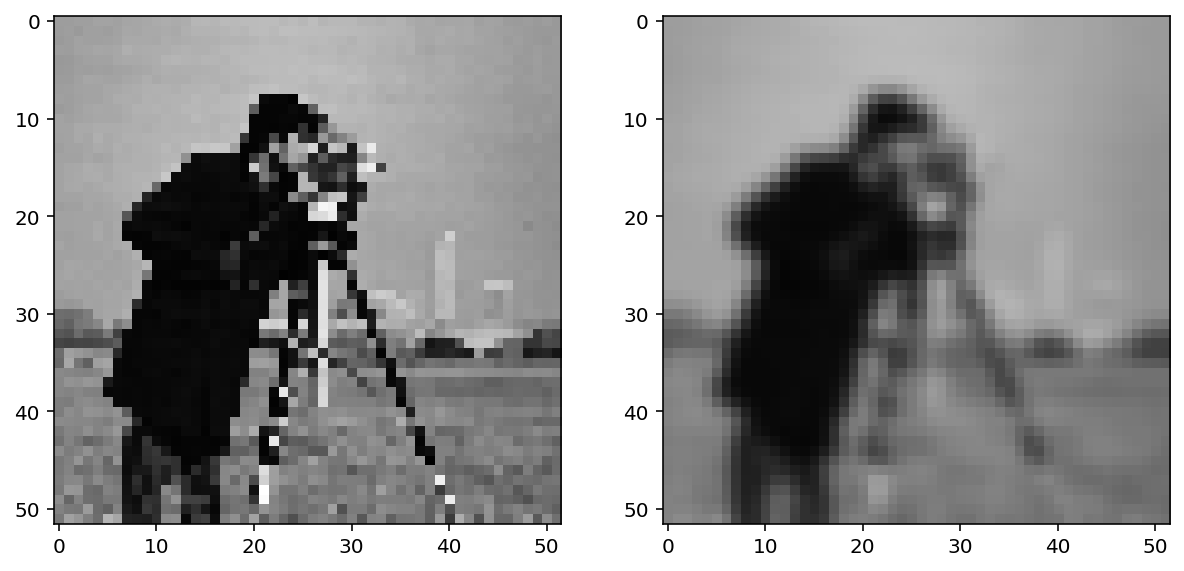

In [65]:
from skimage import img_as_float
# The Gaussian filter returns a float image, regardless of input.
# Cast to float so the images have comparable intensity ranges.
pixelated_float = img_as_float(pixelated)
smooth = filters.gaussian(pixelated_float, sigma=1)
imshow_all(pixelated_float, smooth)

This doesn't look drastically different than the mean filter, but the Gaussian filter is typically preferred because of the distance-dependent weighting, and because it does not have any sharp transitions (consider what happens in the Fourier domain!). For a more detailed image and a larger filter, you can see artifacts in the mean filter since it doesn't take distance into account:

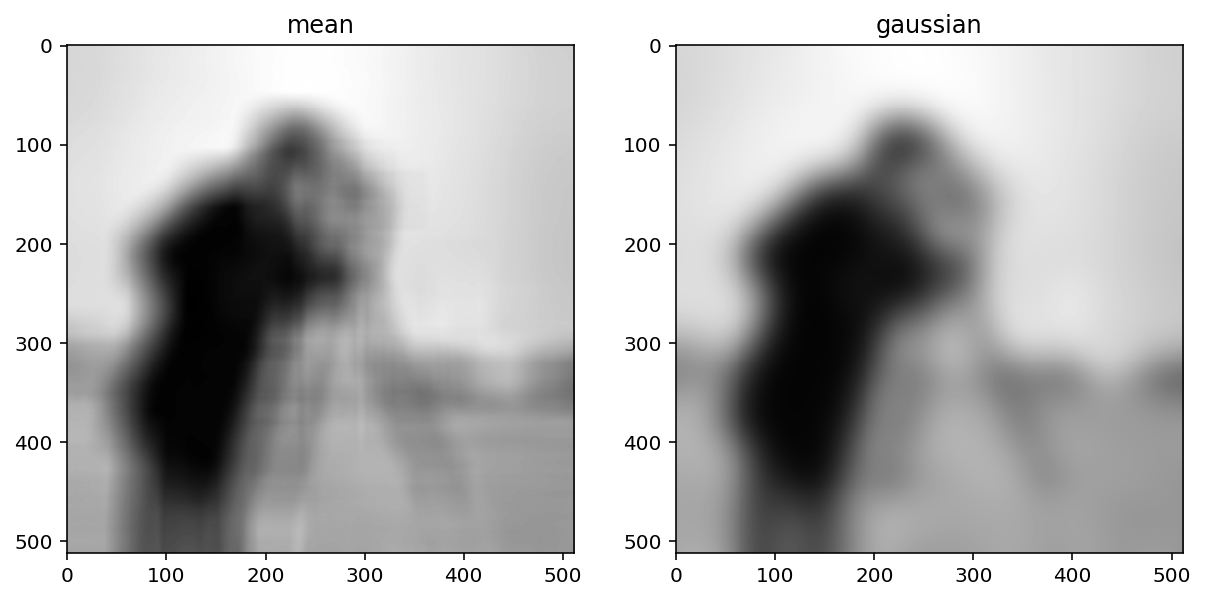

In [66]:
size = 20
structuring_element = np.ones((3*size, 3*size))
smooth_mean = filters.rank.mean(image, structuring_element)
smooth_gaussian = filters.gaussian(image, size)
titles = ['mean', 'gaussian']
imshow_all(smooth_mean, smooth_gaussian, titles=titles)

Incidentally, for reference, let's have a look at what the Gaussian filter actually looks like. Technically, the value of the kernel at a pixel that is $r$ rows and $c$ cols from the center is:

$$
k_{r, c} = \frac{1}{2\pi \sigma^2} \exp{\left(-\frac{r^2 + c^2}{2\sigma^2}\right)}
$$

Practically speaking, this value is pretty close to zero for values more than $4\sigma$ away from the center, so practical Gaussian filters are truncated at about $4\sigma$:

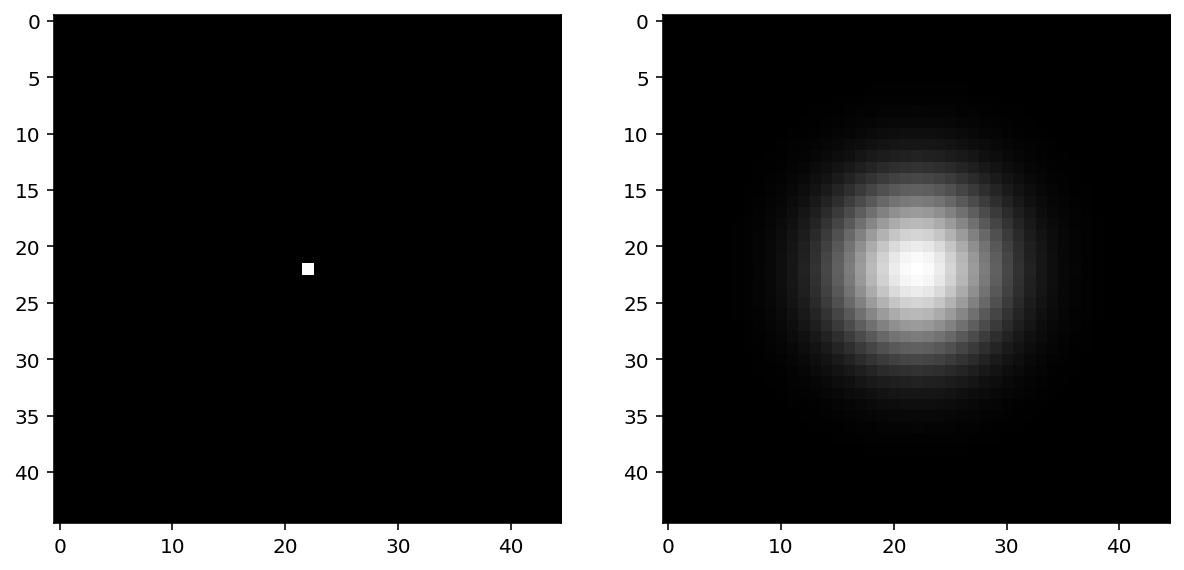

In [67]:
sidelen = 45
sigma = (sidelen - 1) // 2 // 4
spot = np.zeros((sidelen, sidelen), dtype=float)
spot[sidelen // 2, sidelen // 2] = 1
kernel = filters.gaussian(spot, sigma=sigma)

imshow_all(spot, kernel / np.max(kernel))

**Exercise** (Chapter 0 reminder!) Plot the profile of the gaussian kernel at its midpoint, i.e. the values under the line shown here:

(44, 0)

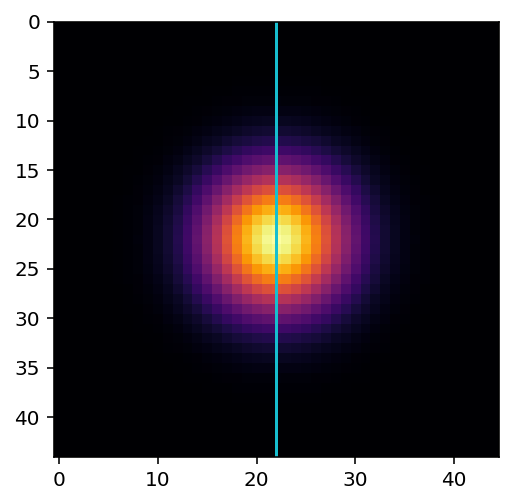

In [68]:
fig, ax = plt.subplots()

ax.imshow(kernel, cmap='inferno')
ax.vlines(22, -100, 100, color='C9')
ax.set_ylim((sidelen - 1, 0))

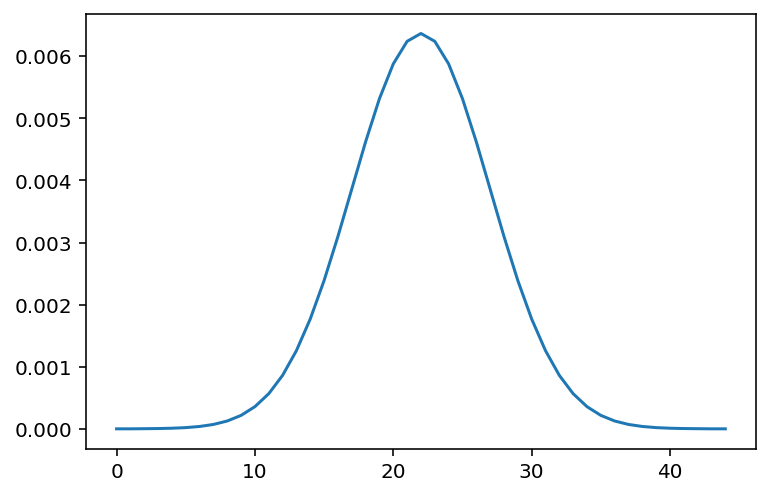

In [69]:
profile = kernel[:, kernel.shape[1]//2]
plt.plot(profile);

(Above, we've tweaked the size of the structuring element used for the mean filter and the standard deviation of the Gaussian filter to produce an approximately equal amount of smoothing in the two results.)

### Basic edge filtering

For images, edges are boundaries between light and dark values. The detection of edges can be useful on its own, or it can be used as preliminary step in other algorithms (which we'll see later).

#### Difference filters in 2D

For images, you can think of an edge as points where the gradient is large in one direction. We can approximate gradients with difference filters.

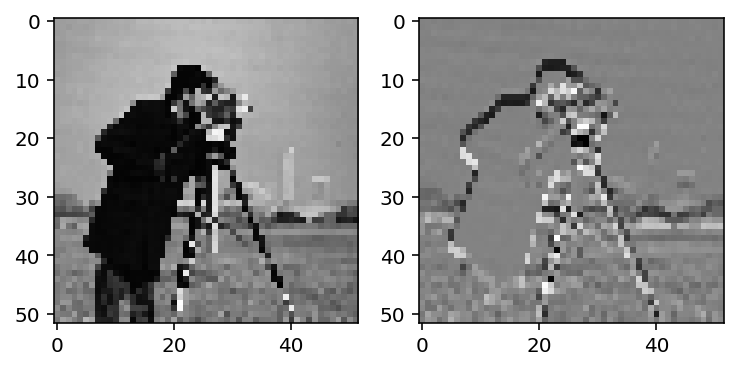

In [71]:
vertical_kernel = np.array([
    [-1],
    [ 0],
    [ 1],
])

gradient_vertical = ndi.correlate(pixelated.astype(float),
                                  vertical_kernel)
fig, ax = plt.subplots(1,2)
ax[0].imshow(pixelated);
ax[1].imshow(gradient_vertical);

## <span style="color:cornflowerblue">Exercise:</span>

- Add a horizontal kernel to the above example to also compute the horizontal gradient, $g_y$
- Compute the magnitude of the image gradient at each point: $\left|g\right| = \sqrt{g_x^2 + g_y^2}$

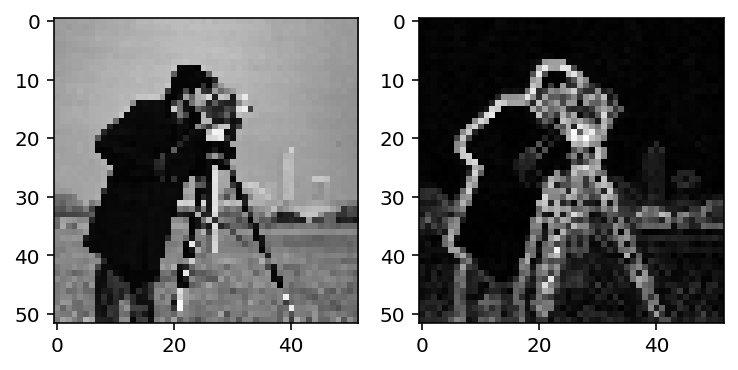

In [72]:
horizontal_kernel = vertical_kernel.T

gradient_horizontal = ndi.correlate(pixelated.astype(float),
                                  horizontal_kernel)

gradient_vertical = ndi.correlate(pixelated.astype(float),
                                  vertical_kernel)

gradient_img = np.sqrt(gradient_horizontal**2+gradient_vertical**2)
fig, ax = plt.subplots(1,2)
ax[0].imshow(pixelated);
ax[1].imshow(gradient_img);

### Sobel edge filter

The Sobel filter, the most commonly used edge filter, should look pretty similar to what you developed above. Take a look at the vertical and horizontal components of the Sobel kernel to see how they differ from your earlier implementation:

* http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.sobel_v
* http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.sobel_h

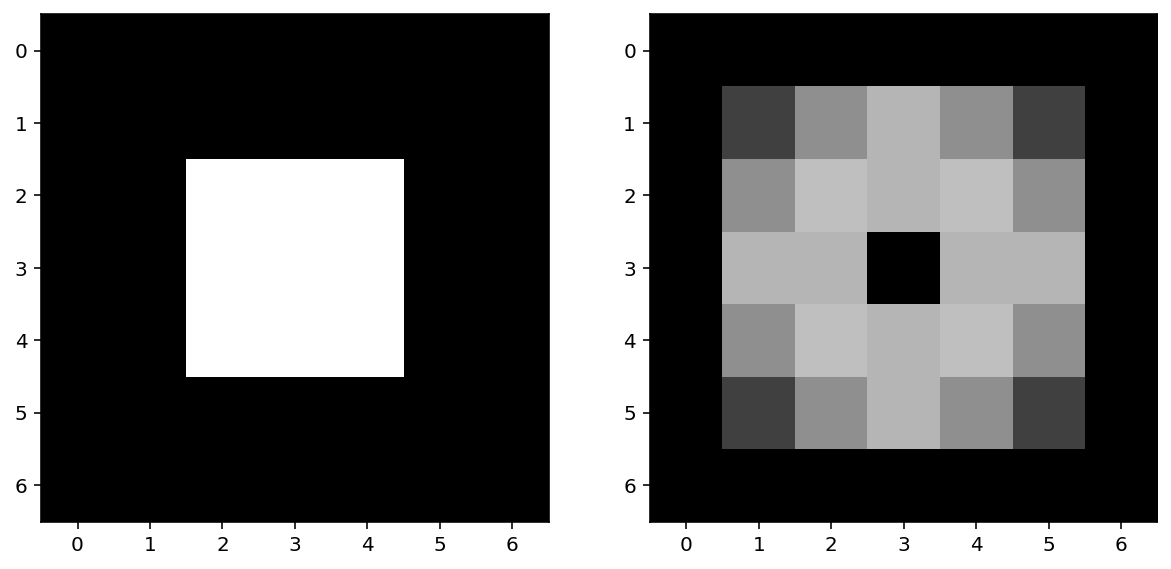

In [73]:
imshow_all(bright_square, filters.sobel(bright_square))

Notice that the size of the output matches the input, and the edges aren't preferentially shifted to a corner of the image. Furthermore, the weights used in the Sobel filter produce diagonal edges with reponses that are comparable to horizontal or vertical edges.

Like any derivative, noise can have a strong impact on the result:

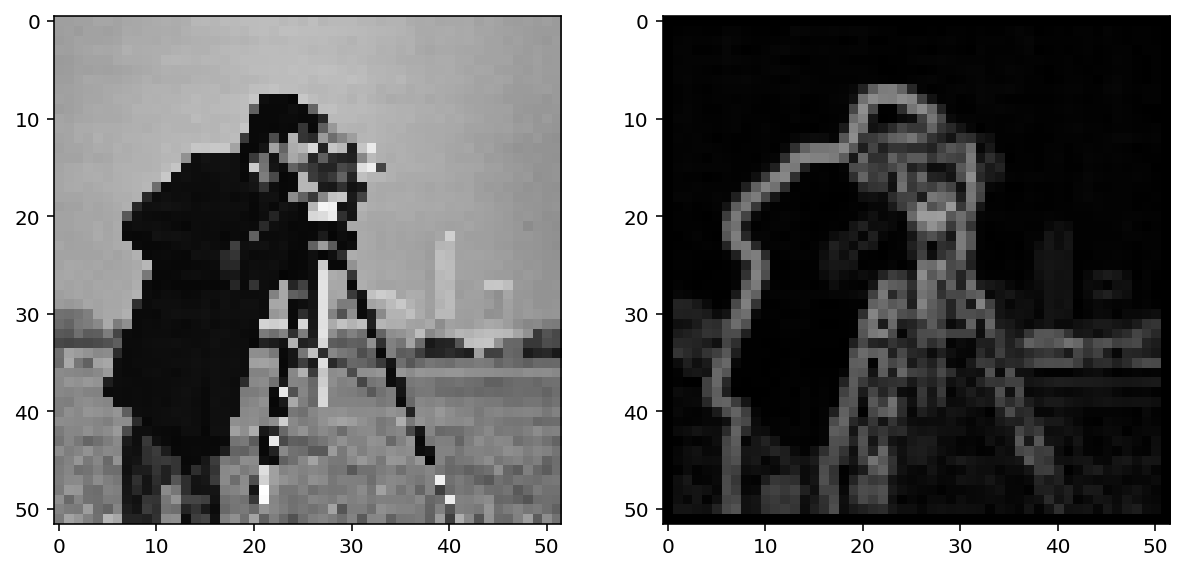

In [74]:
pixelated_gradient = filters.sobel(pixelated)
imshow_all(pixelated, pixelated_gradient)

Smoothing is often used as a preprocessing step in preparation for feature detection and image-enhancement operations because sharp features can distort results.

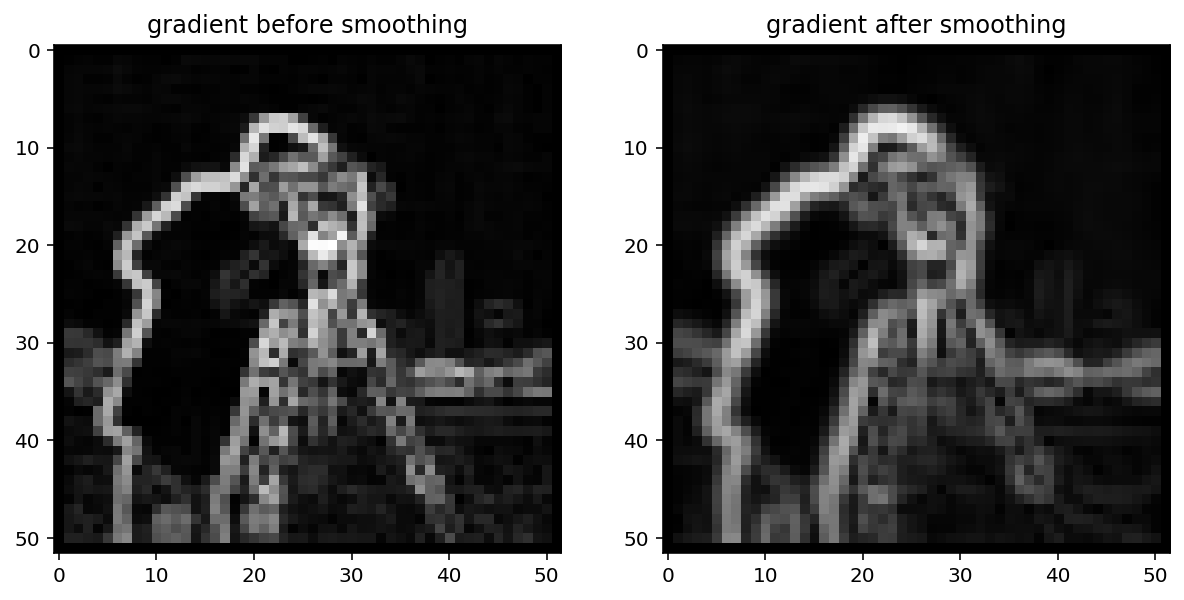

In [75]:
gradient = filters.sobel(smooth)
titles = ['gradient before smoothing', 'gradient after smoothing']
# Scale smoothed gradient up so they're of comparable brightness.
imshow_all(pixelated_gradient, gradient*1.8, titles=titles)

**Exercise: the simplest neural network.** Let's pretend we have an image and a "ground truth" image of what we want to detect:

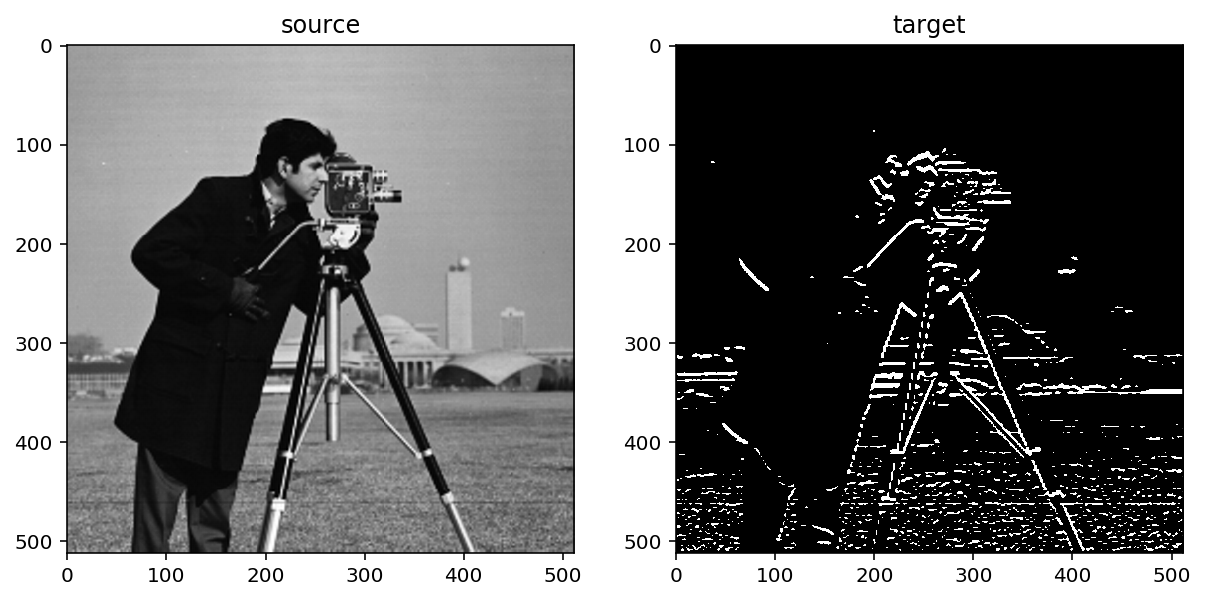

In [76]:
target = (filters.sobel_h(image) > 0.07)
imshow_all(image, target, titles=['source', 'target'])

Can we use machine learning to find a 3x3 convolutional filter that recovers this target?

- use `skimage.util.view_as_windows` and `np.reshape` to view the image as a set of (approximately) `npixels` 3x3 patches. (Hint: why is it only approximate? Think of `mode=valid` convolutions.)
- use `np.reshape` again to see it as `npixels` "linear" patches of 9 pixels.
- Now you have an `(npixels, 9)` "feature" matrix, `X`.
- Use slicing and `np.ravel` to get an `npixels`-length array of target values.
- Use `sklearn.linear_model.LogisticRegression` to learn the relationship between our pixel neighborhoods (of size 9) and the target.
- Look at your `model.coef_`. How do they compare to the Sobel coefficients?

In [81]:
from skimage import util

print(image.shape)
windows = util.view_as_windows(image, (3,3))
print(windows.shape)

print(windows[0,0])
print(image[:3,:3])

X = windows.reshape((510*510), 9)
Y = target[1:-1, 1:-1].ravel()
X.shape, Y.shape

(512, 512)
(510, 510, 3, 3)
[[156 157 160]
 [156 157 159]
 [158 157 156]]
[[156 157 160]
 [156 157 159]
 [158 157 156]]


((260100, 9), (260100,))

In [82]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X,Y)

/home/sunny/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [83]:
clf.coef_.reshape((3,3))

array([[-0.42, -0.81, -0.42],
       [ 0.01, -0.02,  0.02],
       [ 0.41,  0.84,  0.39]])

---------

Notice how the edges look more continuous in the smoothed image.

## Denoising filters

At this point, we make a distinction. The earlier filters were implemented as a *linear dot-product* of values in the filter kernel and values in the image. The following kernels implement an *arbitrary* function of the local image neighborhood. Denoising filters in particular are filters that preserve the sharpness of edges in the image.

As you can see from our earlier examples, mean and Gaussian filters smooth an image rather uniformly, including the edges of objects in an image. When denoising, however, you typically want to preserve features and just remove noise. The distinction between noise and features can, of course, be highly situation-dependent and subjective.

### Median Filter

The median filter is the classic edge-preserving filter. As the name implies, this filter takes a set of pixels (i.e. the pixels within a kernel or "structuring element") and returns the median value within that neighborhood. Because regions near a sharp edge will have many dark values and many light values (but few values in between) the median at an edge will most likely be either light or dark, rather than some value in between. In that way, we don't end up with edges that are smoothed.

[[0 1 0]
 [1 1 1]
 [0 1 0]]


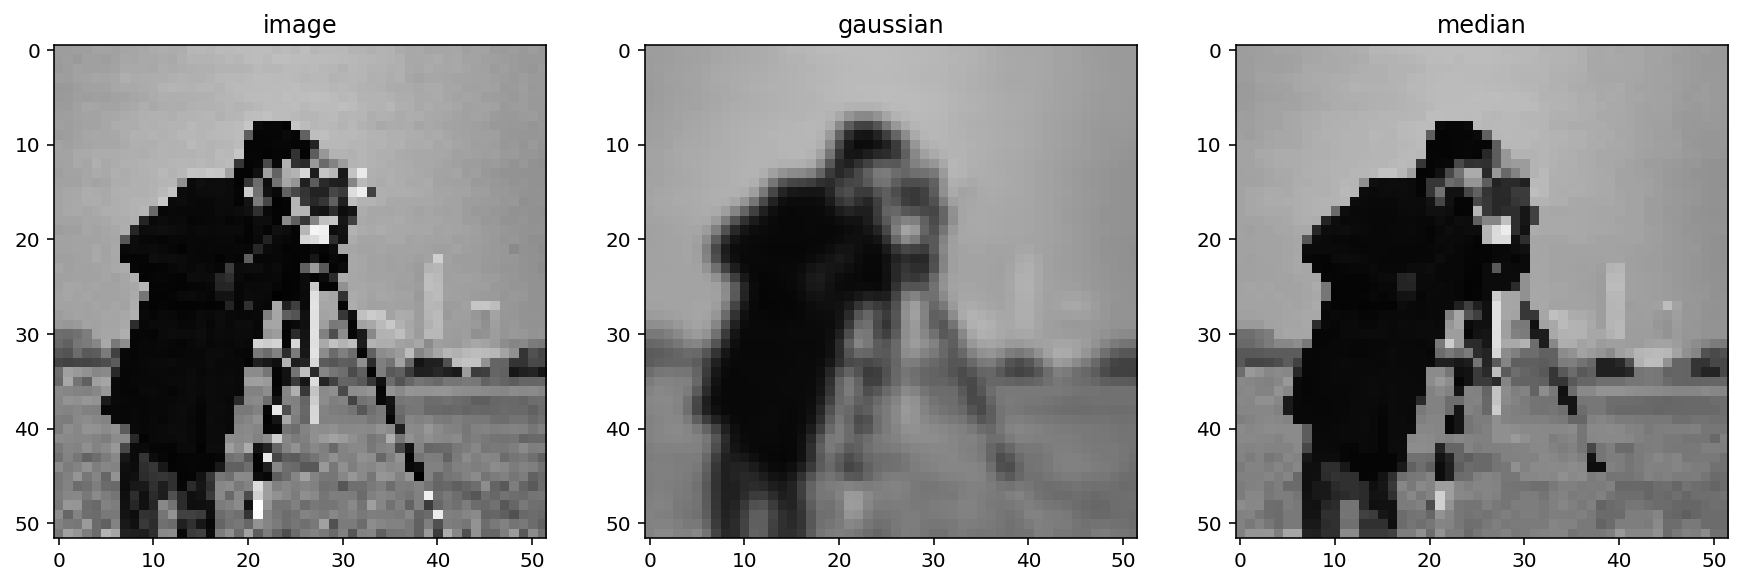

In [85]:
from skimage.morphology import disk
neighborhood = disk(radius=1)  # "selem" is often the name used for "structuring element"
print(neighborhood)
median = filters.rank.median(pixelated, neighborhood)
titles = ['image', 'gaussian', 'median']
imshow_all(pixelated, smooth, median, titles=titles)

This difference is more noticeable with a more detailed image.

[[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
 [0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
 [0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0]
 [0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]
 [0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]]


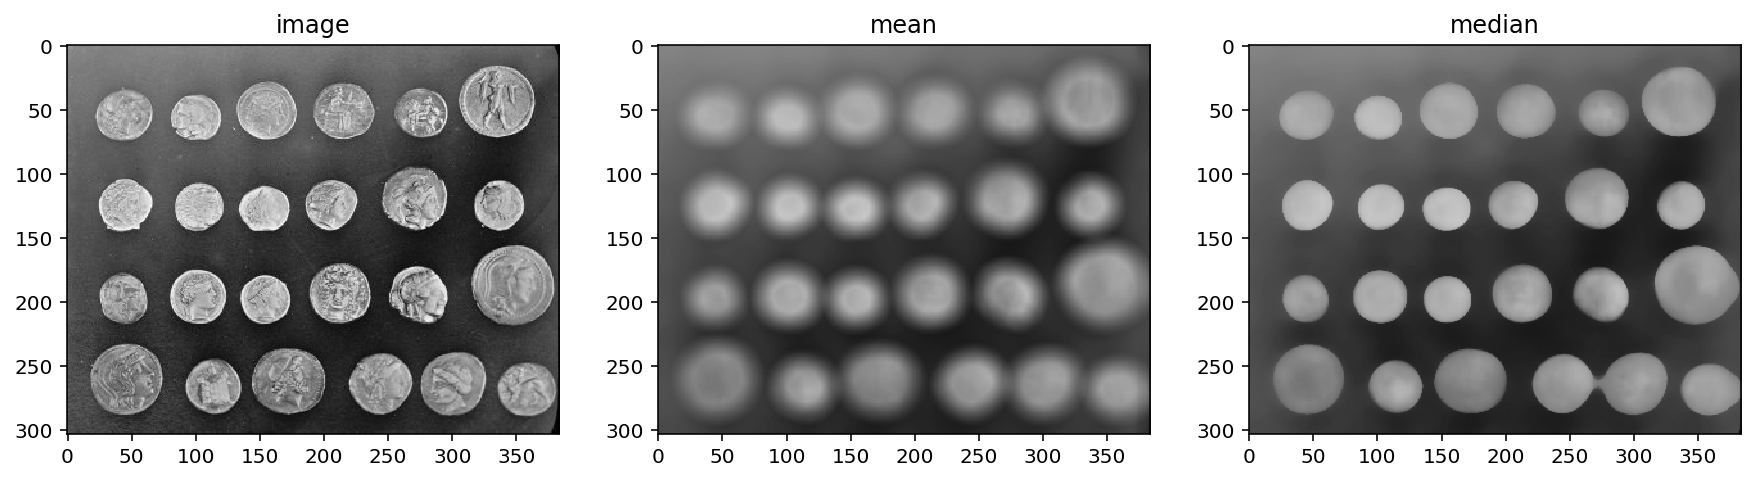

In [86]:
neighborhood = disk(10)
print(neighborhood)
coins = data.coins()
mean_coin = filters.rank.mean(coins, neighborhood)
median_coin = filters.rank.median(coins, neighborhood)
titles = ['image', 'mean', 'median']
imshow_all(coins, mean_coin, median_coin, titles=titles)

Notice how the edges of coins are preserved after using the median filter.

## Further reading

`scikit-image` also provides more sophisticated denoising filters:

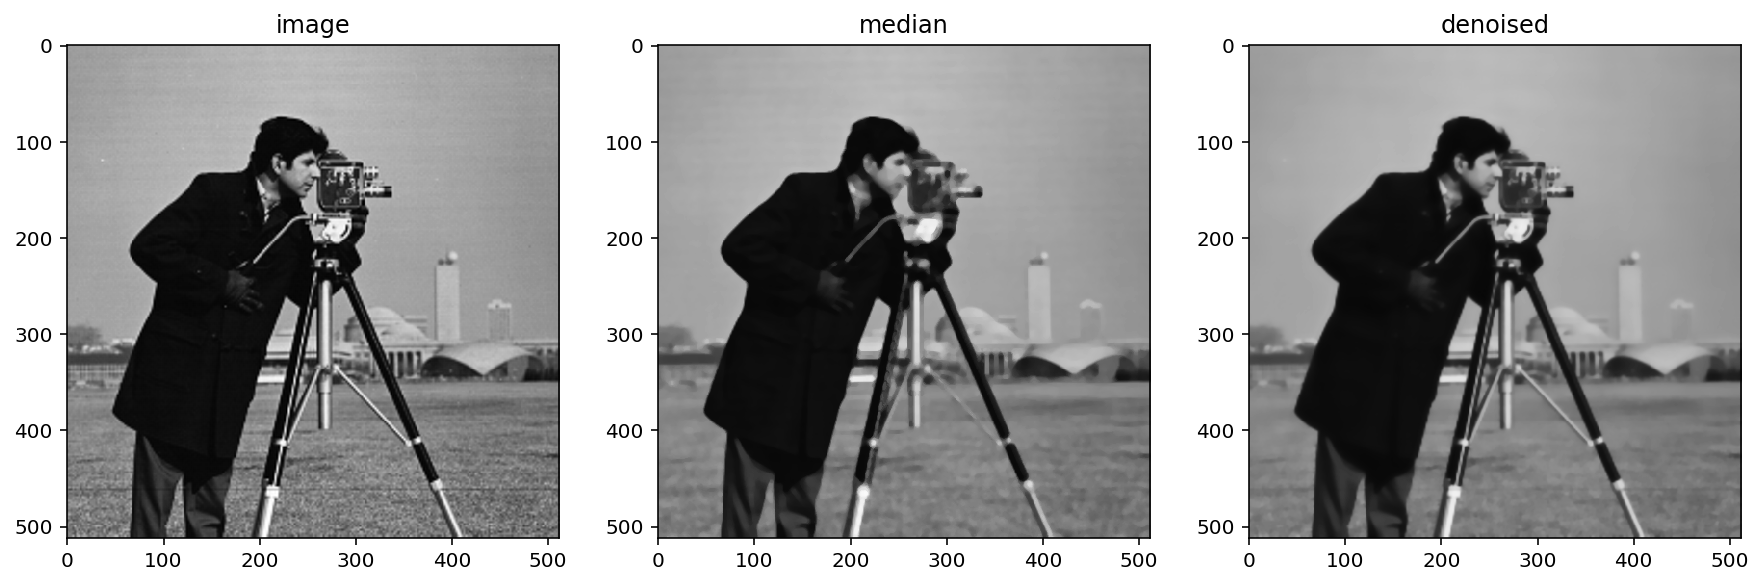

In [87]:
from skimage.restoration import denoise_tv_bregman
denoised = denoise_tv_bregman(image, 4)
d = disk(4)
median = filters.rank.median(image, d)
titles = ['image', 'median', 'denoised']
imshow_all(image, median, denoised, titles=titles)

* [Denoising examples](http://scikit-image.org/docs/dev/auto_examples/plot_denoise.html)
* [Rank filters example](http://scikit-image.org/docs/dev/auto_examples/applications/plot_rank_filters.html)
* [Restoration API](http://scikit-image.org/docs/stable/api/skimage.restoration.html)

Take a look at this [neat feature](https://github.com/scikit-image/scikit-image/pull/2647) merged last year:

![cycle spinning](../images/cycle_spin.png)